In [1]:
# check the affect of L1 prefiring issue in run2 
# check the distribution before and after removal of affected objects
import ROOT as rt
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import make_datacard_2sig, make_datacard_2tag, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [18]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]


old_ctau = {
#     'STodd_ms3p0':[100,500],
#     'SToEE_ms0p4':[10,50],
#     'SToGammaGamma_ms0p4':[10,50],
#     'SToKPlusKMinus_ms1p5':[38,187],
#     'SToK0K0_ms1p5':[38,187],
#     'SToPi0Pi0_ms0p4':[10,50],
#     'SToPi0Pi0_ms1p0':[25,125],
#     'SToPiPlusPiMinus_ms0p4':[10,50],
#     'SToPiPlusPiMinus_ms1p0':[25,125],
    'STodd_ms7':[100, 1000, 10000, 100000],
    'STodd_ms15':[100, 1000, 10000, 100000],
    'STodd_ms40':[100, 1000, 10000, 100000],
    'STodd_ms55':[100, 1000, 10000, 100000],
#     'SToTauTau_ms7':[100, 1000, 10000, 100000],
#     'SToTauTau_ms15':[100, 1000, 10000, 100000],
#     'SToTauTau_ms40':[100, 1000, 10000, 100000],
#     'SToTauTau_ms55':[100, 1000, 10000, 100000],
#     'SToBB_ms15':[100, 1000, 10000, 100000],
#     'SToBB_ms40':[100, 1000, 10000, 100000],
#     'SToBB_ms55':[100, 1000, 10000, 100000],
#     'SToEE_ms4p0':[100,500],
#     'SToGammaGamma_ms4p0':[100,500],
#     'SToPiPlusPiMinus_ms4p0':[100,500],
    
}

# prod = ['ggH', 'VBFH','ZH', 'WH', 'ttH','ggZH']
prod=['ggH']

ntupler_version = 'V1p17/'
mc_path = {}
analyzer_version = 'v1/v163/'
mc_central_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
analyzer_version = 'v2/v163/'
mc_private_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'


for p in prod:
#     if 'WH' in p:continue
    for k in old_ctau.keys():
        for ct in old_ctau[k]:

            key = 'MC_'+p+'_'+k + '_'+str(ct)
            if (p == 'ggH' or p == 'VBFH') and ('ms7' in k or 'ms15' in k or 'ms40' in k or 'ms55' in k) and not (p =='VBFH' and 'dd' in k):
                mass = k[k.find('ms')+2:]
                if 'dd' in k and p == 'ggH':fpath[key] = mc_central_path+p+'_HToSSTodddd_MH-125_MS-'+mass+'_ctau-'+str(ct)+'_137000pb_weighted.root'
                elif 'BB' in k and p =='ggH':fpath[key] = mc_central_path+p+'_HToSSTobbbb_MH-125_MS-'+mass+'_ctau-'+str(ct)+'_137000pb_weighted.root'
                elif 'BB' in k and p =='VBFH':fpath[key] = mc_central_path+p+'_HToSSTo4b_MH-125_MS-'+mass+'_ctau-'+str(ct)+'_137000pb_weighted.root'
                else:fpath[key] = mc_central_path+p+'_HToSSTo4Tau_MH-125_MS-'+mass+'_ctau-'+str(ct)+'_137000pb_weighted.root'
            else:
                
                if 'ggH' in p or 'ttH' in p: fpath[key] = mc_private_path+p+'_HToSS_'+k+'_pl'+str(ct)+'_137000pb_weighted.root'
                elif p == 'VBFH' or p=='ZH' or p == 'WH': fpath[key] = mc_private_path+p+'ToSS_'+k+'_pl'+str(ct)+'_137000pb_weighted.root'
                elif 'ggZH' in p:fpath[key] = mc_private_path+'ZHToSS_'+k+'_pl'+str(ct)+'_137000pb_weighted.root'
            if not os.path.exists(fpath[key]):print(key, fpath[key])
            

            
# mass = [15, 40, 55]
# if not decay == 'bbbb': mass = [7, 15, 40, 55]

# OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

# ntupler_version = 'V1p17/'


                     
NEvents = {}
# NEvents_genweight = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
#     NEvents[k] = root_dir['NEvents'][1]
    NEvents[k] = root_dir['NEvents']._fEntries
    print(k)
#     if not 'data' in k: 
#         print(k, root_dir['NEvents']._fEntries)


root_dir = uproot.open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root') 
h_reweight = root_dir['higgsPthiggsEta']

MC_ggH_STodd_ms7_100
MC_ggH_STodd_ms7_1000
MC_ggH_STodd_ms7_10000
MC_ggH_STodd_ms7_100000
MC_ggH_STodd_ms15_100
MC_ggH_STodd_ms15_1000
MC_ggH_STodd_ms15_10000
MC_ggH_STodd_ms15_100000
MC_ggH_STodd_ms40_100
MC_ggH_STodd_ms40_1000
MC_ggH_STodd_ms40_10000
MC_ggH_STodd_ms40_100000
MC_ggH_STodd_ms55_100
MC_ggH_STodd_ms55_1000
MC_ggH_STodd_ms55_10000
MC_ggH_STodd_ms55_100000


# nCsc with different hit vetoing

In [26]:

jetPt_cut = 50

weight = {}
nhits1 = {}
nhits2 = {}
sel_ev = {}
cond = {}
ggZH_weight = {}
higgsEta = {}
higgsPt = {}
EE_prefiring = {}
cluster_index = ''
addNoiseFlag = 1
# 0: 2 CSC; 1: 2DT; 2: csc+dt
category =2


for k in list(tree.keys()):
#     if  'data' in k:continue
########### SELECTION: CLUSTERS ############
    if 'data' in k: T = tree['data']
    else: T = tree[k]

    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

    if 'data' in k: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))
    else: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))
        
    sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId'))))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    
    cut = 5
    station = (T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))

    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) #remove if both clusters are 4 stations
    if addNoiseFlag and not 'data' in k: 
        sel_dtcluster = np.logical_and(sel_dtcluster, (T.array('dtRechitClusterSize')+T.array('dtRechitClusterNoiseHit')) >= 50)
    else: sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitClusterSize') >= 50)




    ###################### cosmic muon veto #############
    sel_cosmic = np.logical_and(T.array('dtRechitClusterNOppositeSegStation1')>0, T.array('dtRechitClusterNOppositeSegStation2')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation3')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation4')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation1')+T.array('dtRechitClusterNOppositeSegStation2')+\
                               T.array('dtRechitClusterNOppositeSegStation3')+T.array('dtRechitClusterNOppositeSegStation4')>=6)
    nstation = (T.array('dtRechitClusterNSegmentStation1')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>1).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>1).astype(int)
    
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(nstation>=3, sel_cosmic)))
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)


            
########### SELECTION: NOISE IN DT ############
    
    spike = np.logical_and( T.array('nDTRechitsSector')[:,0,0,7]>50,  T.array('nDTRechitsSector')[:,0,0,7]+T.array('nDTRechitsSector')[:,0,0,8]+T.array('nDTRechitsSector')[:,0,0,9]>120)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,8]>25)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,9]>10)

    
    
########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METNoMuTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') >= 200)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    sel_ev[k] = np.logical_and(sel_ev[k] , np.logical_not(spike))

########### BRANCHES ############


                     
                            
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 2)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum()== 0)
        cond[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0],\
                        T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,1], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,1])<2
        
       
        nhits1[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][cond[k]][:,0]
        nhits2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][cond[k]][:,1]
#         deltaRCluster[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0],\
#                         T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,1], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,1])
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum()== 2)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 0)
        cond[k] = np.abs(T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,0]-\
                                                    T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,1])>=0
        if addNoiseFlag and not 'data' in k:
            nhits1[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][:,0]
            nhits2[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][:,1]
        else:
            nhits1[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,0]
            nhits2[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,1]
    elif category == 2:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        
#         cond[k] =  np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0]-\
#                                                     T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,0])<2.0
       
        cond[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0],\
                        T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,0], T.array('dtRechitCluster' + cluster_index + 'Phi')[sel_dtcluster][sel_ev[k]][:,0])<2.5
        if addNoiseFlag and not 'data' in k:
            nhits1[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][cond[k]][:,0]
        else:
            nhits1[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][cond[k]][:,0]
        nhits2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][cond[k]][:,0]
        


    else:
        assert(False)

    
    higgsPt[k] = T.array('gHiggsPt')[sel_ev[k]][cond[k]]
    higgsEta[k] = T.array('gHiggsEta')[sel_ev[k]][cond[k]]
    
    ggZH_weight[k]=h_reweight.values[np.argmax(h_reweight.edges[0]>higgsPt[k][:,None],axis=1)-1, np.argmax(h_reweight.edges[1]>np.abs(higgsEta[k])[:,None],axis=1)-1]
    
    EE_prefiring[k] = T.array('EE_prefiring')[sel_ev[k]][cond[k]]

    if 'ggH' in k: weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]][cond[k]]
    else:weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev[k]][cond[k]]
    if 'ggZH' in k: weight[k] *= ggZH_weight[k]
    

# plots 

MC_ggH_STodd_ms7_100 0.0028207898139953613
MC_ggH_STodd_ms7_1000 0.01281893253326416
MC_ggH_STodd_ms7_10000 -0.08343625068664551
MC_ggH_STodd_ms7_100000 nan
MC_ggH_STodd_ms15_100 -0.01313483715057373
MC_ggH_STodd_ms15_1000 -0.0009387731552124023


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in float_scalars


MC_ggH_STodd_ms15_10000 -0.04349946975708008
MC_ggH_STodd_ms15_100000 nan
MC_ggH_STodd_ms40_100 nan
MC_ggH_STodd_ms40_1000 -0.0065108537673950195
MC_ggH_STodd_ms40_10000 -0.010281205177307129
MC_ggH_STodd_ms40_100000 0.0
MC_ggH_STodd_ms55_100 nan
MC_ggH_STodd_ms55_1000 0.006004512310028076
MC_ggH_STodd_ms55_10000 -0.015658974647521973
MC_ggH_STodd_ms55_100000 -0.11176073551177979


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/category2_MC_ggH_STodd_ms7_100_nDtHits.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/category2_MC_ggH_STodd_ms7_100_nDtHits.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/category2_MC_ggH_STodd_ms7

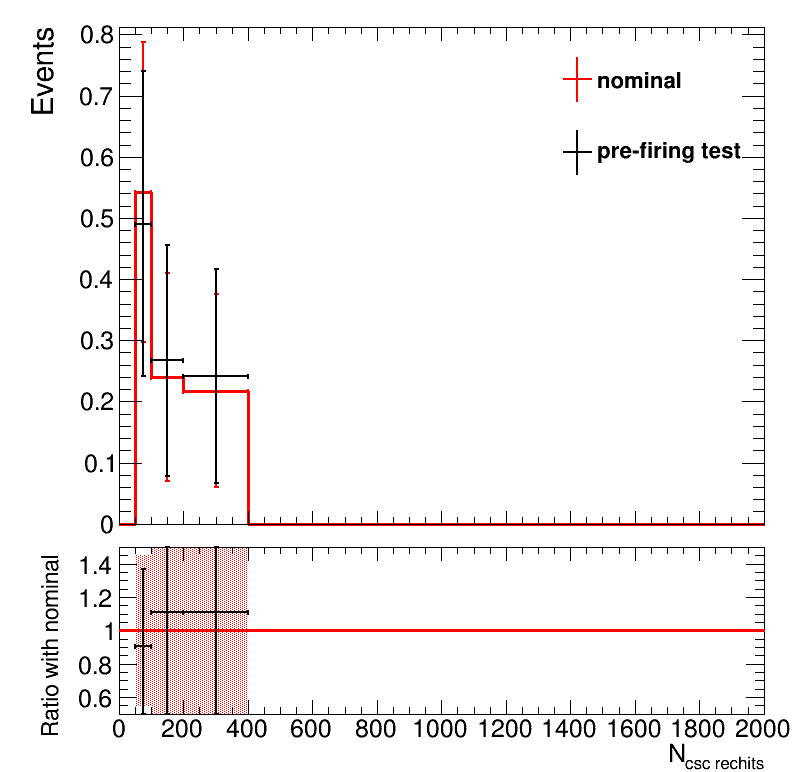

In [36]:
assert(category == 2)



leg = rt.TLegend(0.5,0.7,0.85,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)

rt.gStyle.SetOptFit(1011)
h = {}


var = [nhits1, nhits2]
name = ['nDtHits','nCscHits']
bins = [[0,50,100,200,400,600,800,1000,1250, 1500,2000]]*2
xaxis = ['N_{dt rechits}', 'N_{csc rechits}']
for j in range(len(var)):
#     if not j == 1:continue
    for i, k in enumerate(tree.keys()):
        if j == 0:
            eff = np.sum(weight[k][np.logical_and(nhits1[k]>=80, nhits2[k]>=100)])/np.sum(weight[k])
            eff_ee = np.sum(weight[k][np.logical_and(EE_prefiring[k], np.logical_and(nhits1[k]>=80, nhits2[k]>=100))])/np.sum(weight[k][EE_prefiring[k]])
            print(k, 1-eff_ee/eff)
        if k == 'data':continue
        if np.count_nonzero(EE_prefiring[k])==0 or len(var[j][k])==0:continue
        h[k] = create_TH1D(np.abs(var[j][k]),axis_title=[xaxis[j], 'Events'],binning = bins[j], weights = weight[k])
        h[k+'EE'] = create_TH1D(np.abs(var[j][k])[EE_prefiring[k]],axis_title=[xaxis[j], 'Events'],binning = bins[j],  weights = weight[k][EE_prefiring[k]])
        
        h[k].SetLineColor(std_color_list[1])
        h[k+'EE'].SetLineColor(std_color_list[0])

        h[k].SetLineWidth(3)
        
        if h[k].Integral() == 0 or h[k+'EE'].Integral()==0:continue
        h[k].Scale(1./h[k].Integral())
        h[k+'EE'].Scale(1./h[k+'EE'].Integral())
        

        h[k].GetXaxis().SetTitleOffset(1)


        c = make_ratio_plot([h[k], h[k+'EE']], fit = False, logy=False, in_tags = ["nominal","pre-firing test"],ratio_index = 0,\
                            ratio_bounds = [0.5,1.5], draw_opt = ['E1','E1']) 


        c.Draw()
        output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/'


        if not os.path.isdir(output_dir):os.makedirs(output_dir)
        c.SaveAs(output_dir+'category'+str(category)+'_'+k+'_'+name[j]+'.png')
        c.SaveAs(output_dir+'category'+str(category)+'_'+k+'_'+name[j]+'.C')






# csc-csc or dt-dt

MC_ggH_STodd_ms7_100 0.0006994009017944336
MC_ggH_STodd_ms7_1000 0.0077933669090271
MC_ggH_STodd_ms7_10000 0.0
MC_ggH_STodd_ms7_100000 nan
MC_ggH_STodd_ms15_100 0.0
MC_ggH_STodd_ms15_1000 0.007482349872589111


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in float_scalars


MC_ggH_STodd_ms15_10000 0.008989930152893066
MC_ggH_STodd_ms15_100000 nan
MC_ggH_STodd_ms40_100 nan
MC_ggH_STodd_ms40_1000 0.0026541948318481445
MC_ggH_STodd_ms40_10000 0.0025919675827026367
MC_ggH_STodd_ms40_100000 0.0
MC_ggH_STodd_ms55_100 nan
MC_ggH_STodd_ms55_1000 -0.0017750263214111328
MC_ggH_STodd_ms55_10000 -0.008205175399780273
MC_ggH_STodd_ms55_100000 0.0


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/category1_MC_ggH_STodd_ms7_100_nhits.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/category1_MC_ggH_STodd_ms7_100_nhits.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/category1_MC_ggH_STodd_ms7_100

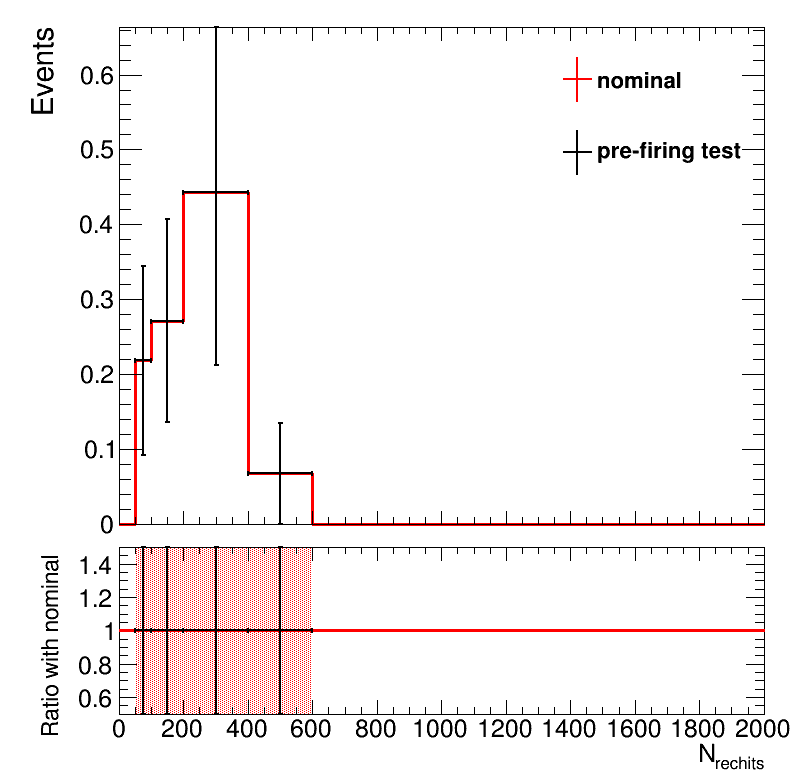

In [24]:
assert(category < 2)
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot




leg = rt.TLegend(0.5,0.7,0.85,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
# ctaus_m = ctaus/1000
h = {}

name = 'nhits'
bins = [0,50,100,200,400,600,800,1000,1250, 1500,2000]
xaxis  = 'N_{rechits}'
for i, k in enumerate(tree.keys()):
    if category == 0:threshold = 100
    else: threshold = 80
        
    eff = np.sum(weight[k][np.logical_and(nhits1[k]>=threshold, nhits2[k]>=threshold)])/np.sum(weight[k])
    eff_ee = np.sum(weight[k][np.logical_and(EE_prefiring[k], np.logical_and(nhits1[k]>=threshold, nhits2[k]>=threshold))])/np.sum(weight[k][EE_prefiring[k]])
    
    
    print(k, 1-eff_ee/eff)
    if k == 'data':continue
#     if not i == 1:continue
    if np.count_nonzero(EE_prefiring[k])==0:continue
#     print(k, np.count_nonzero(EE_prefiring[k]))

    h[k] = create_TH1D(np.hstack((nhits1[k],nhits2[k])),axis_title=[xaxis, 'Events'],binning = bins, weights = np.hstack((weight[k],weight[k])))
    h[k+'EE'] = create_TH1D(np.hstack((nhits1[k][EE_prefiring[k]],nhits2[k][EE_prefiring[k]])),axis_title=[xaxis, 'Events'],binning = bins,  \
                            weights = np.hstack((weight[k][EE_prefiring[k]],weight[k][EE_prefiring[k]])))

    h[k].SetLineColor(std_color_list[1])
    h[k+'EE'].SetLineColor(std_color_list[0])

    h[k].SetLineWidth(3)
    h[k].Scale(1./h[k].Integral())

    h[k+'EE'].Scale(1./h[k+'EE'].Integral())


    h[k].GetXaxis().SetTitleOffset(1)


    c = make_ratio_plot([h[k], h[k+'EE']], fit = False, logy=False, in_tags = ["nominal","pre-firing test"],ratio_index = 0,\
                        ratio_bounds = [0.5,1.5], draw_opt = ['E1','E1']) 


    c.Draw()
    output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/EE_prefiring/'


    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    c.SaveAs(output_dir+'category'+str(category)+'_'+k+'_'+name+'.png')
    c.SaveAs(output_dir+'category'+str(category)+'_'+k+'_'+name+'.C')


